# Convolutional Neural Network

In [6]:
import pandas as pd
from finlab.data import Data
data = Data()
twii = data.get("發行量加權股價指數")
twii = twii['台股指數']
twii = twii.resample('15T').first().dropna() #每15分鐘取樣第一個收盤價

## 製作features

In [7]:
import numpy as np
import tqdm
time_period = 200

#由於cnn可以額外加入時間序列的資訊，因此我們可以直接將時間序列的資料丟進去
cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.tqdm_notebook(range(0, len(twii) - time_period - 1 - 11, 3)):
    s = twii.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min())) #normalize
    r = twii.iloc[i+time_period+10] / twii.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(twii.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)




C:\Users\jerry\AppData\Local\Temp\ipykernel_4384\2692381262.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0, len(twii) - time_period - 1 - 11, 3)):


  0%|          | 0/25960 [00:00<?, ?it/s]

## Reshape features and labels

1.0115834671246686


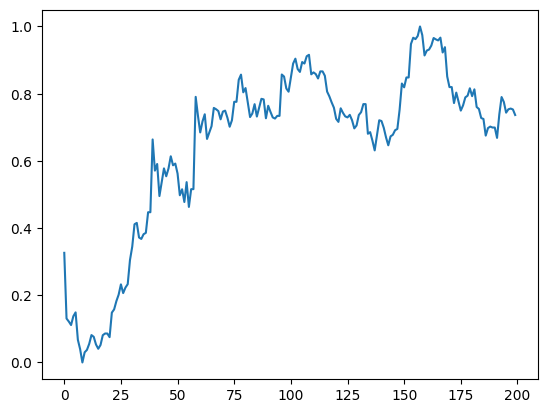

In [8]:
import matplotlib.pyplot as plt

plt.plot(cnn_x[0])
print(cnn_y[0])

In [9]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

## Split traning and testing data

In [12]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2016,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2016,1,1)]

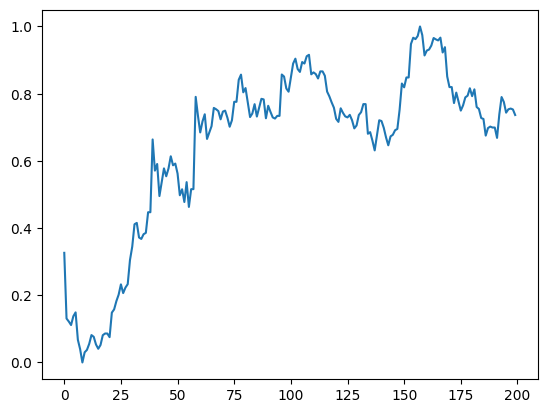

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


## CNN

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = cnn_x[0].shape
time_period = 200
num_classes = 1

model = keras.Sequential() #建立一個序列模型

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.AveragePooling1D(5)) #將長度為5的區間取平均

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(layers.AveragePooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

model.compile(loss='mse',
                optimizer=adam)

print(model.summary())

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1, )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 181, 20)           420       
                                                                 
 average_pooling1d (AverageP  (None, 36, 20)           0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 20)            8020      
                                                                 
 average_pooling1d_1 (Averag  (None, 3, 20)            0         
 ePooling1D)                                                     
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 120)               7

d:\Anaconda\envs\fintech2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


71/71 [==============================] - 8s 6ms/step - loss: 0.1801 - val_loss: 0.0203
Epoch 2/50
71/71 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0046
Epoch 3/50
71/71 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/50
71/71 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/50
71/71 [==============================] - 0s 3ms/step - loss: 6.8911e-04 - val_loss: 8.4342e-04
Epoch 6/50
71/71 [==============================] - 0s 3ms/step - loss: 4.9556e-04 - val_loss: 6.8117e-04
Epoch 7/50
71/71 [==============================] - 0s 4ms/step - loss: 3.8748e-04 - val_loss: 5.4324e-04
Epoch 8/50
71/71 [==============================] - 0s 3ms/step - loss: 2.9724e-04 - val_loss: 3.8095e-04
Epoch 9/50
71/71 [==============================] - 0s 3ms/step - loss: 2.3042e-04 - val_loss: 2.5474e-04
Epoch 10/50
71/71 [==============================] - 0s 3ms/step - loss: 1.9286e-04 - val

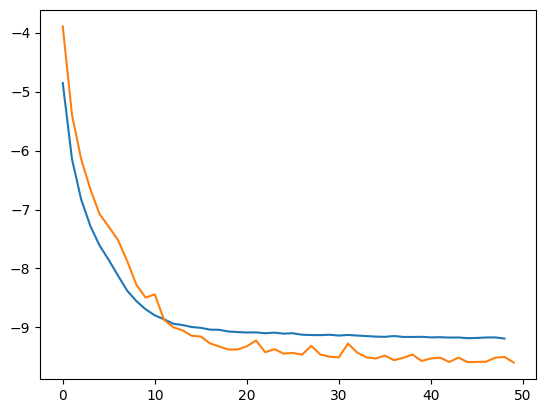

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][1:]))
plt.plot(np.log(history.history['val_loss']))

In [15]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

812/812 [==============================] - 1s 942us/step


<Axes: >

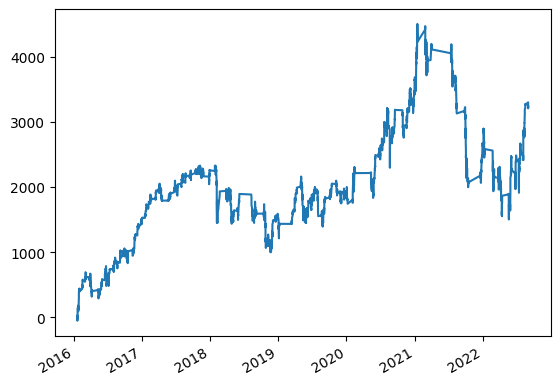

In [16]:

eq = twii[pd.to_datetime(indexes)]
gain = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0
eq = (gain[signal])['2016':].cumsum()
eq.plot()

In [17]:
signal['2016':].astype(int).diff().abs().sum()

185.0